In [1]:
from models.SchNETPeriodic import SchNet_model
from utils import AtomGraphConverter, process_gold_input, inference_gold
from train import AuMD_SE_config as config
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from ase.db import connect

In [2]:
db = connect('data/gold.db')

query = ['xc=PBE']
results = list(db.select(query))
results_amorphous = list(db.select(['xc=PBE', f'cluster={'amorphous'}']))
results_bulk = list(db.select(['xc=PBE','bulk']))

In [3]:
# data preprocessing
converter = AtomGraphConverter(cutoff=6.0, max_neighbors=50)
# in-domain data: bulk structures
indomain_data = process_gold_input(results_bulk, converter)
# out-of-domain data: amorphous structures
outofdomain_data = process_gold_input(results_amorphous, converter)
test_loader_in = DataLoader(indomain_data, batch_size=1, shuffle=False)
test_loader_out = DataLoader(outofdomain_data, batch_size=1, shuffle=False)


In [4]:
# model checkpoint loading
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SchNet_model(**config.model_config).to(device)
model.load_state_dict(torch.load('checkpoints/AuMD-SE.pth', map_location=device, weights_only=False), strict=False)
model.eval() 

SchNet_model(hidden_channels=1024, num_filters=256, num_interactions=5, num_gaussians=200, cutoff=6.0)

In [5]:
# model inference
pred_per_atom_in, true_per_atom_in, var_per_atom_in= inference_gold(model, test_loader_in, device)
pred_per_atom_out, true_per_atom_out, var_per_atom_out = inference_gold(model, test_loader_out, device)

# 1. Bulk & Amorphous systems

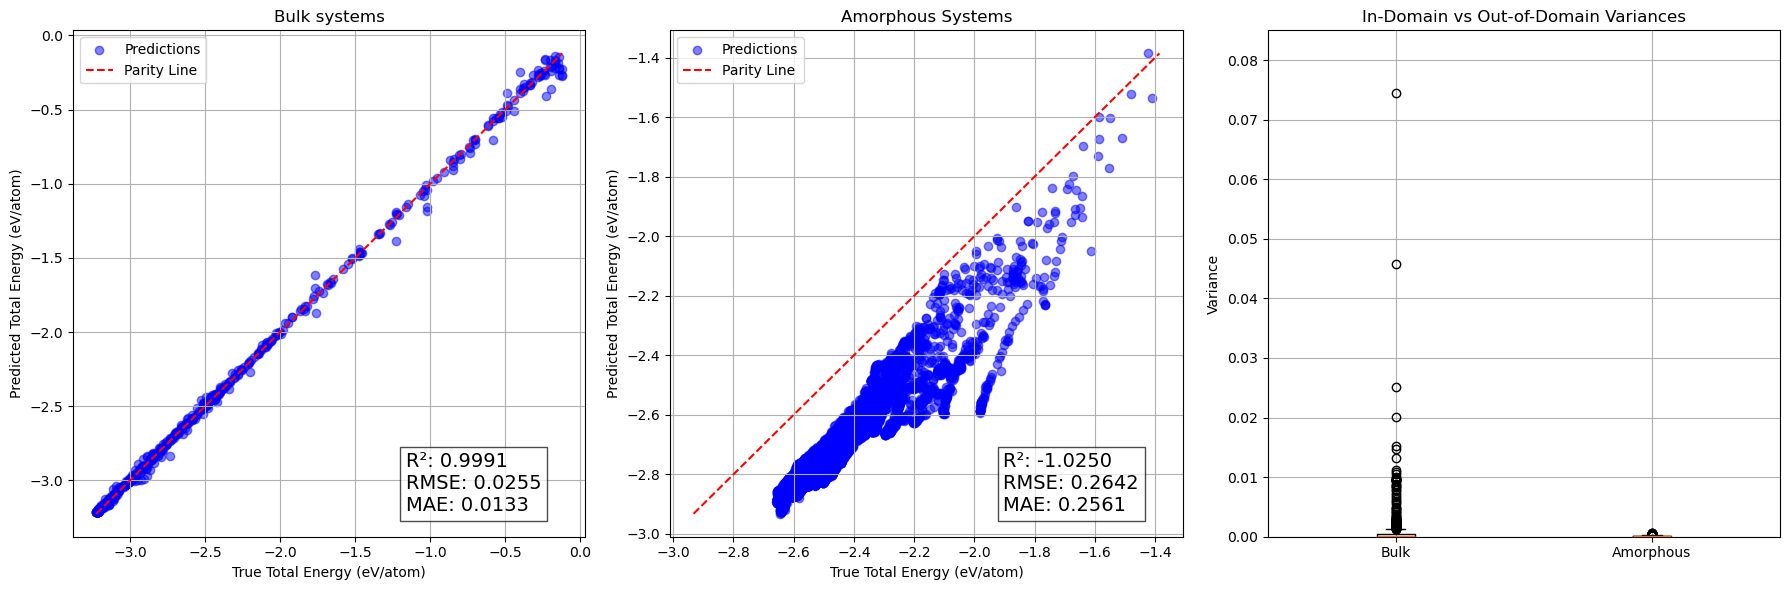

In [6]:
# Calculate metrics for both in-domain and out-of-domain
r2_in = r2_score(true_per_atom_in, pred_per_atom_in)
mae_in = mean_absolute_error(true_per_atom_in, pred_per_atom_in)
rmse_in = np.sqrt(mean_squared_error(true_per_atom_in, pred_per_atom_in))

r2_out = r2_score(true_per_atom_out, pred_per_atom_out)
mae_out = mean_absolute_error(true_per_atom_out, pred_per_atom_out)
rmse_out = np.sqrt(mean_squared_error(true_per_atom_out, pred_per_atom_out))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Parity plot for in-domain
axs[0].scatter(true_per_atom_in, pred_per_atom_in, alpha=0.5, label='Predictions', color='b')
min_val, max_val = min(true_per_atom_in + pred_per_atom_in), max(true_per_atom_in + pred_per_atom_in)
axs[0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Parity Line')

axs[0].set_xlabel('True Total Energy (eV/atom)')
axs[0].set_ylabel('Predicted Total Energy (eV/atom)')
axs[0].set_title('Bulk systems')
axs[0].legend()
axs[0].grid(True)
axs[0].text(0.65, 0.05, f'R²: {r2_in:.4f}\nRMSE: {rmse_in:.4f}\nMAE: {mae_in:.4f}', 
            transform=axs[0].transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.7))

# Plot 2: Parity plot for out-of-domain
axs[1].scatter(true_per_atom_out, pred_per_atom_out, alpha=0.5, label='Predictions', color='b')
min_val, max_val = min(true_per_atom_out + pred_per_atom_out), max(true_per_atom_out + pred_per_atom_out)
axs[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Parity Line')

axs[1].set_xlabel('True Total Energy (eV/atom)')
axs[1].set_ylabel('Predicted Total Energy (eV/atom)')
axs[1].set_title('Amorphous Systems')
axs[1].legend()
axs[1].grid(True)
axs[1].text(0.65, 0.05, f'R²: {r2_out:.4f}\nRMSE: {rmse_out:.4f}\nMAE: {mae_out:.4f}', 
            transform=axs[1].transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.7))

# Plot 3: Boxplot for variances
axs[2].boxplot([var_per_atom_in, var_per_atom_out], tick_labels=['Bulk', 'Amorphous'])
axs[2].set_ylim(0, 0.085)
axs[2].set_title('In-Domain vs Out-of-Domain Variances')
axs[2].set_ylabel('Variance')
axs[2].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# 2. Energy-Variance-Error analysis

In [7]:
test_loader = DataLoader(indomain_data+outofdomain_data, batch_size=1, shuffle=False)
pred_per_atom, true_per_atom, var_per_atom= inference_gold(model, test_loader, device)

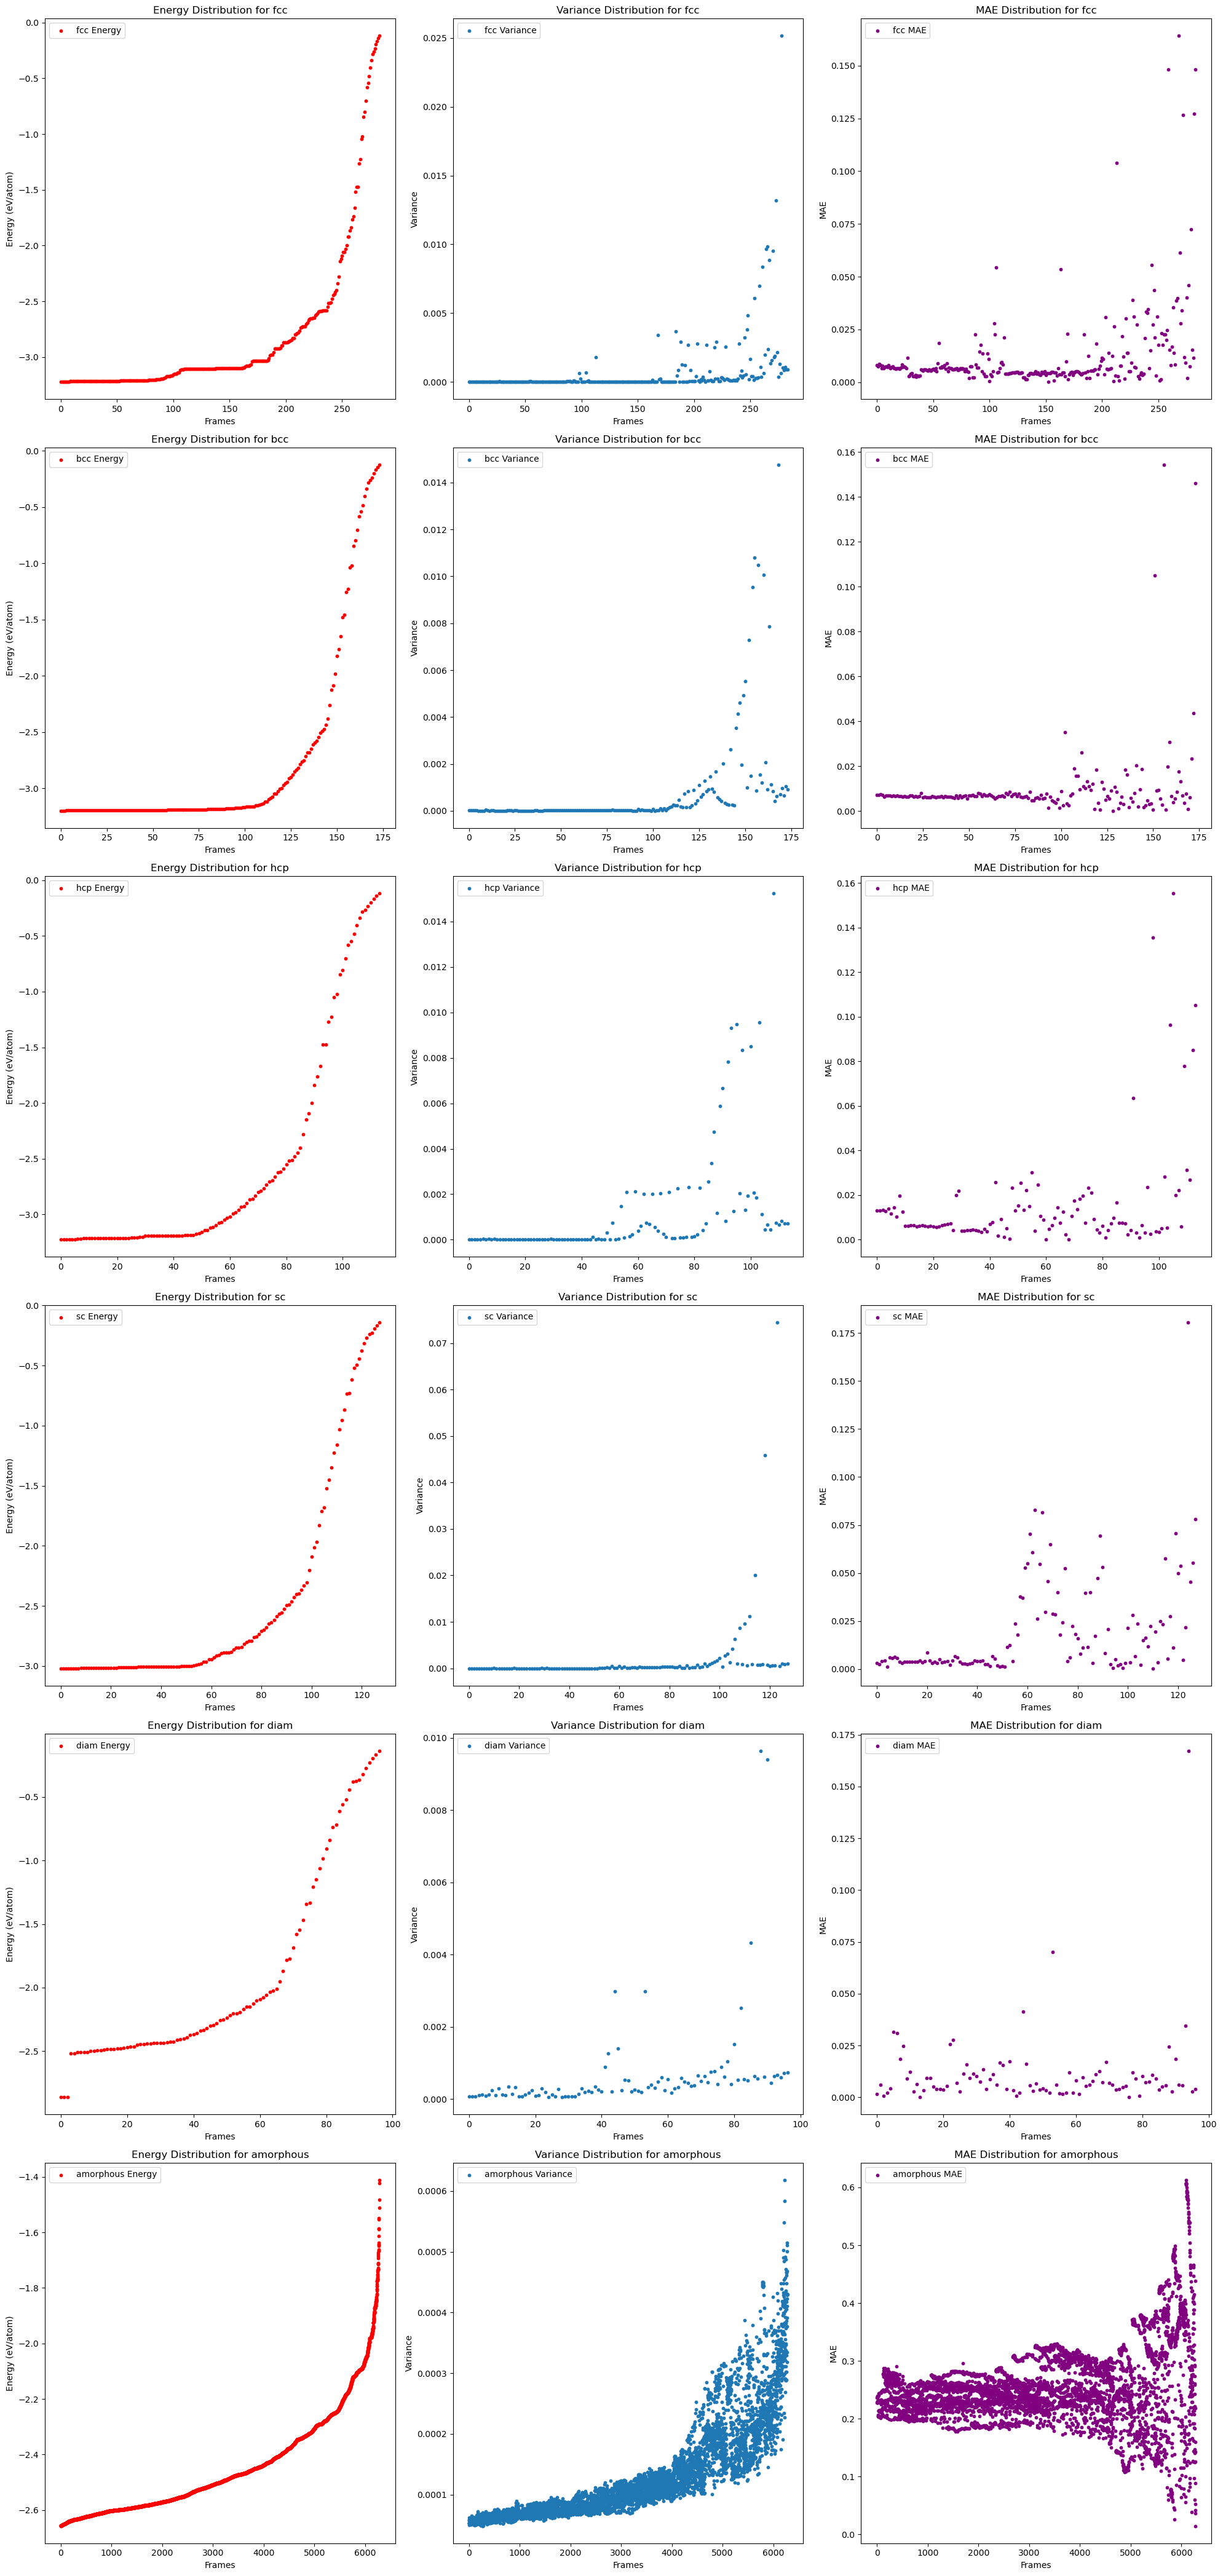

In [8]:
# Step 1: Create defaultdicts to store variance, energy, fmax, and MAE values for each spec
spec_variances = defaultdict(list)
spec_energies = defaultdict(list)
spec_mae = defaultdict(list)

# Step 2: Populate the dictionaries with variance, energy, fmax, and MAE based on 'spec'
for i, data in enumerate(indomain_data + outofdomain_data):
    # if data.spec =='diam' or data.spec == 'amorphous':
        spec_variances[data.spec].append(var_per_atom[i])
        spec_energies[data.spec].append(data.y_atom)
        
        # Calculate MAE error per data point
        mae_error = abs(true_per_atom[i] - pred_per_atom[i])
        spec_mae[data.spec].append(mae_error)

# Step 3: Calculate min, max, mean, median statistics for each spec
spec_stats = {}
for spec, variances in spec_variances.items():
    energies = spec_energies[spec]
    mae_errors = spec_mae[spec]

    # Variance statistics
    min_variance = np.min(variances)
    max_variance = np.max(variances)
    mean_variance = np.mean(variances)
    median_variance = np.median(variances)

    # Energy statistics
    min_energy = np.min(energies)
    max_energy = np.max(energies)
    mean_energy = np.mean(energies)
    median_energy = np.median(energies)

    # MAE statistics
    min_mae = np.min(mae_errors)
    max_mae = np.max(mae_errors)
    mean_mae = np.mean(mae_errors)
    median_mae = np.median(mae_errors)

    count = len(variances)  # Number of data points for each spec group

    # Store all stats in the dictionary
    spec_stats[spec] = {
        'min_variance': min_variance,
        'max_variance': max_variance,
        'mean_variance': mean_variance,
        'median_variance': median_variance,
        'min_energy': min_energy,
        'max_energy': max_energy,
        'mean_energy': mean_energy,
        'median_energy': median_energy,
        'min_mae': min_mae,
        'max_mae': max_mae,
        'mean_mae': mean_mae,
        'median_mae': median_mae,
        'count': count
    }

# Plot variance, energy, fmax, and MAE distributions for each 'spec' group

# Create a figure and subplots (4 plots for each 'spec' group)
fig, axs = plt.subplots(len(spec_variances), 3, figsize=(20, 7 * len(spec_variances)))
# fig, axs = plt.subplots(2, 3, figsize=(20, 10))
# Make sure axs is always treated as an array, even with a single subplot
if len(spec_variances) == 1:
    axs = [axs]

# Plot the distributions for each 'spec' group
for ax_energy, ax_var, ax_mae, (spec, variances) in zip(axs[:, 0], axs[:, 1], axs[:, 2], spec_variances.items()):
        # Get corresponding energies, fmax, and MAE values for the current spec
    energies = spec_energies[spec]

    mae_errors = spec_mae[spec]

    # Sort indices by energies for consistent plotting
    sort_indices = np.argsort(energies)
    variances_sort = np.array(variances)[sort_indices]
    energies_sort = np.array(energies)[sort_indices]

    mae_sort = np.array(mae_errors)[sort_indices]


    # Scatter plot for energy
    ax_energy.scatter(range(len(energies_sort)), energies_sort, s=10, color='r', label=f'{spec} Energy')
    ax_energy.set_title(f'Energy Distribution for {spec}')
    ax_energy.set_xlabel('Frames')
    ax_energy.set_ylabel('Energy (eV/atom)')
    ax_energy.legend()

    # Scatter plot for variance
    ax_var.scatter(range(len(variances_sort)), variances_sort, s=10, label=f'{spec} Variance')
    ax_var.set_title(f'Variance Distribution for {spec}')
    ax_var.set_xlabel('Frames')
    ax_var.set_ylabel('Variance')
    ax_var.legend()


    # Scatter plot for MAE
    ax_mae.scatter(range(len(mae_sort)), mae_sort, s=10, color='purple', label=f'{spec} MAE')
    ax_mae.set_title(f'MAE Distribution for {spec}')
    ax_mae.set_xlabel('Frames')
    ax_mae.set_ylabel('MAE')
    ax_mae.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
